Episode 1, Total Reward: -5
Episode 2, Total Reward: -5
Episode 3, Total Reward: -5
Episode 4, Total Reward: -5
Episode 5, Total Reward: -5
Episode 6, Total Reward: -5
Episode 7, Total Reward: -5
Episode 8, Total Reward: -5
Episode 9, Total Reward: -5
Episode 10, Total Reward: -5
Episode 11, Total Reward: -5
Episode 12, Total Reward: -5
Episode 13, Total Reward: -5
Episode 14, Total Reward: -5
Episode 15, Total Reward: -5
Episode 16, Total Reward: -5
Episode 17, Total Reward: -5
Episode 18, Total Reward: -5
Episode 19, Total Reward: -5
Episode 20, Total Reward: -5
Episode 21, Total Reward: -5
Episode 22, Total Reward: -5
Episode 23, Total Reward: -5
Episode 24, Total Reward: -5
Episode 25, Total Reward: -5
Episode 26, Total Reward: -5
Episode 27, Total Reward: -5
Episode 28, Total Reward: -5
Episode 29, Total Reward: -5
Episode 30, Total Reward: -5
Episode 31, Total Reward: -5
Episode 32, Total Reward: -5
Episode 33, Total Reward: -5
Episode 34, Total Reward: -5
Episode 35, Total Rewar

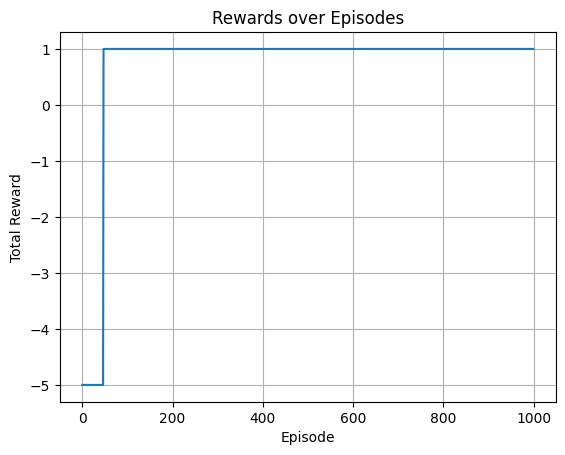

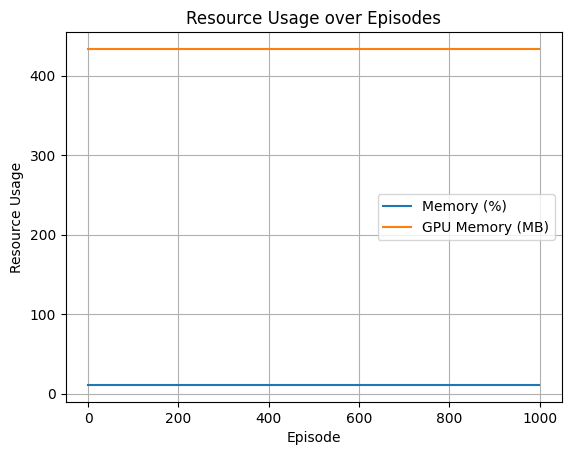

In [9]:
import numpy as np
import json
import gym
import matplotlib.pyplot as plt
import psutil
import pynvml
from collections import Counter
from gym.envs.registration import register

# Register the wrapper with a new environment ID
register(
    id='CustomRewardFrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=1,  # Adjust the reward threshold if needed
)

class CustomRewardFrozenLake(gym.Env):
    def __init__(self):
        self.env = gym.make("CustomRewardFrozenLake-v1")
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if reward == 0 and not done:
            reward = 0
        elif reward == 0 and done:
            reward = -5
        elif reward == 1:
            reward = 1
        return state, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

class ProblemSolver:
    def __init__(self, num_actions, env, lambda_=0.9):
        self.num_actions = num_actions
        self.Q_values = np.zeros((env.observation_space.n, num_actions))
        self.eligibility_traces = np.zeros_like(self.Q_values)
        self.lambda_ = lambda_

    def choose_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
            return np.random.choice(self.num_actions)  # Random action
        else:
            return np.argmax(self.Q_values[state])  # Greedy action

    def update_Q(self, state, action, reward, next_state, next_action, alpha, gamma):
        # Calculate TD error
        td_error = reward + gamma * self.Q_values[next_state, next_action] - self.Q_values[state, action]
        
        # Update eligibility trace
        self.eligibility_traces *= gamma * self.lambda_
        self.eligibility_traces[state, action] += 1
        
        # Update Q-values
        self.Q_values += alpha * td_error * self.eligibility_traces



class Case:
    added_states = set()  # Class attribute to store states already added to the case base

    def __init__(self, problem, solution, trust_value=1):
        self.problem = np.array(problem)  # Convert problem to numpy array
        self.solution = solution
        self.trust_value = trust_value
    
    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)  # Ensure state1 is at least 1-dimensional
        state2 = np.atleast_1d(state2)  # Ensure state2 is at least 1-dimensional
        CNDMaxDist = 6  # Maximum distance between two nodes in the CND
        v = state1.size  # Total number of objects the agent can perceive
        DistQ = np.sum([Case.Dmin_phi(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def Dmin_phi(X1, X2):
        return np.max(np.abs(X1 - X2))
    

    @staticmethod
    def retrieve(state, case_base, threshold=0.2):
        similarities = {}
        for case in case_base:
            similarities[case] = Case.sim_q(state, case.problem)  # Compare state with the problem part of the case
        
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        
        if sorted_similarities:
            most_similar_case = sorted_similarities[0][0] if sorted_similarities[0][1] >= threshold else None
        else:
            most_similar_case = None
        
        return most_similar_case

    @staticmethod
    def reuse(c, temporary_case_base):
        temporary_case_base.append(c)
        # Store the new case from the problem solver
        # if c not in temporary_case_base:
            # temporary_case_base.append(c)
        
        # Check if there are similar cases in case_base
        # similar_cases = [case for case in case_base if np.array_equal(case.problem, c.problem)]
        # for similar_case in similar_cases:
            # temporary_case_base.append(similar_case)
            # if similar_case not in temporary_case_base:
            #     temporary_case_base.append(similar_case)

    @staticmethod
    def revise(case_base, temporary_case_base, successful_episodes):
        for case in temporary_case_base:
            if successful_episodes and case in case_base:
                case.trust_value += 0.1  # Increment trust value if the episode ended successfully and the case is in the case base
            elif not successful_episodes and case in case_base:
                case.trust_value -= 0.1  # Decrement trust value if the episode ended unsuccessfully and the case is in the case base
            case.trust_value = max(0, min(case.trust_value,1))  # Ensure trust value is within[0,1]

    @staticmethod
    def retain(case_base, temporary_case_base, successful_episodes, threshold=0):
        if successful_episodes:
            # Iterate through the temporary case base to find the last occurrence of each unique state
            for case in reversed(temporary_case_base):
                state = tuple(np.atleast_1d(case.problem))
                # Check if the state is already in the case base or has been added previously
                if state not in Case.added_states:
                    # Add the case to the case base if the state is new
                    case_base.append(case)
                    Case.added_states.add(state)
            
            # Filter case_base based on trust_value
            filtered_case_base = []
            for case in case_base:
                # print(f"trust value >= Threshold?: {case.trust_value} >= {threshold}?")
                if case.trust_value >= threshold:
                    # print(f"problem | trust value: {case.problem} | {case.trust_value}")
                    # print("case saved dong")
                    filtered_case_base.append(case)
                else:
                    # print(f"problem | trust value: {case.problem} | {case.trust_value}")
                    # print("case unsaved dong")
                    pass

            return filtered_case_base
        else:
            return case_base  # Return original case_base if episode is not successful

            
class QCBRL:
    def __init__(self, num_actions, env):
        self.num_actions = num_actions
        self.env = env
        self.problem_solver = ProblemSolver(num_actions, env)
        self.case_base = []
        self.temporary_case_base = []

    def run(self, episodes=100, max_steps=100, alpha=0.1, gamma=0.9, epsilon=0.1, render=False):
        rewards = []
        # episode_rewards = []
        memory_usage = []
        gpu_memory_usage = []
        successful_episodes = False
        num_successful_episodes = 0

        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        for episode in range(episodes):
            state = self.env.reset()
            episode_reward = 0
            self.temporary_case_base = []
            

            for _ in range(max_steps):
                if render:
                    env.render()
                action = self.take_action(state, epsilon)
                next_state, reward, done, _ = self.env.step(action)

                # print(f"State: {state} - Action: {action} - Reward: {reward} - Done: {done}")

                c = Case(state, action)
                Case.reuse(c, self.temporary_case_base)

                next_action = self.take_action(next_state, epsilon)
                self.problem_solver.update_Q(state, action, reward, next_state, next_action, alpha, gamma)

                state = next_state
                episode_reward += reward

                if done:
                    successful_episodes = reward > 0
                    break
                
                
            if episode_reward > 0:  # If the agent reached the goal state
                num_successful_episodes += 1

            rewards.append(episode_reward)
            print(f"Episode {episode + 1}, Total Reward: {episode_reward}")

            Case.revise(self.case_base, self.temporary_case_base, successful_episodes)
            self.case_base = Case.retain(self.case_base, self.temporary_case_base, successful_episodes)
            
            memory_usage.append(psutil.virtual_memory().percent)
            gpu_memory_usage.append(pynvml.nvmlDeviceGetMemoryInfo(handle).used / 1024**2)

        
        self.save_case_base_temporary()  # Save temporary case base after training
        self.save_case_base()  # Save case base after training

        success_rate = (num_successful_episodes / episodes) * 100
        # print(f"Successful episodes: {num_successful_episodes}%")

        # env.close()
        return rewards, success_rate, memory_usage, gpu_memory_usage

    def take_action(self, state, epsilon):

        similar_solution = Case.retrieve(state, self.case_base)
        if similar_solution is not None:
            action = similar_solution.solution
            # print("action from case base")
        else:
            action = self.problem_solver.choose_action(state, epsilon)
            # print("action from problem solver")
        
        # action = self.problem_solver.choose_action(state, epsilon)
        
        return action
    
    def save_case_base_temporary(self):
        filename = "case_base_temporary.json"
        case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else int(case.problem), 
                        "solution": int(case.solution), 
                        "trust_value": int(case.trust_value)} for case in self.temporary_case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)
        print("Temporary case base saved successfully.")

    def save_case_base(self):
        filename = "case_base.json"
        case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else int(case.problem), 
                        "solution": int(case.solution), 
                        "trust_value": int(case.trust_value)} for case in self.case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

            print("Case base saved successfully.")  # Add this line to check if the case base is being saved
        
    def load_case_base(self):
        filename = "case_base.json"
        try:
            with open(filename, 'r') as file:
                case_base_data = json.load(file)
                self.case_base = [Case(np.array(case["problem"]), case["solution"], case["trust_value"]) for case in case_base_data]
                print("Case base loaded successfully.")  # Add this line to check if the case base is being loaded
        except FileNotFoundError:
            print("Case base file not found. Starting with an empty case base.")

    
    def display_success_rate(self, success_rate):
        print(f"Success rate: {success_rate}%")


    def plot_rewards(self, rewards):
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Rewards over Episodes')
        plt.grid(True)
        plt.show() 

    def plot_resources(self, memory_usage, gpu_memory_usage):
        plt.plot(memory_usage, label='Memory (%)')
        plt.plot(gpu_memory_usage, label='GPU Memory (MB)')
        plt.xlabel('Episode')
        plt.ylabel('Resource Usage')
        plt.title('Resource Usage over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    env = CustomRewardFrozenLake()
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    agent = QCBRL(num_actions, env)
    rewards, success_rate, memory_usage, gpu_memory_usage = agent.run(episodes=1000, max_steps=1000, alpha=0.1, gamma=0.9, epsilon=0.1)

    agent.display_success_rate(success_rate)
    agent.plot_rewards(rewards)
    agent.plot_resources(memory_usage, gpu_memory_usage)